In [75]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import random
import time


In [76]:
print(tf.__version__)

print("GPU Available:", tf.test.is_gpu_available())

if tf.test.is_gpu_available():
    device_name = tf.config.list_physical_devices('GPU')

else:
    device_name = 'cpu:0'

print(device_name)

2.10.1
GPU Available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [85]:
dataset = pd.read_csv('AudiosDataset.csv')
print(dataset.head())

             name          transcription
0  Luz/frase1.wav  Avocado is delicious.
1  Luz/frase2.wav    Titanic was tragic.
2  Luz/frase3.wav    Humor is essential.
3  Luz/frase4.wav  Emotions are intense.
4  Luz/frase5.wav      Brain is complex.


In [86]:
len(dataset)

100

In [87]:
# Comprobar el tamaño del dataset
print(f"Size of dataset: {len(dataset)}")

# Dividir el dataset en train y validation
cantidad = 100
split_array = list(np.random.permutation(np.arange(0, len(dataset)))[:len(dataset)])
split_train = split_array[0:int(cantidad * 0.90)]
split_val = split_array[int(cantidad * 0.90):cantidad]

df_train = dataset.iloc[split_train]
df_val = dataset.iloc[split_val]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of dataset: 100
Size of the training set: 90
Size of the validation set: 10


In [88]:
def check_audio_shapes(df):
    for wav_file in df["name"]:
        if not os.path.exists(wav_file):
            print(f"File {wav_file} does not exist.")
            continue
        file = tf.io.read_file(wav_file)
        audio, _ = tf.audio.decode_wav(file, desired_channels=1)
        shape = tf.shape(audio)
        print(f"{wav_file} shape: {shape}")

# Verificar las formas de los archivos en el DataFrame
check_audio_shapes(df_train)
check_audio_shapes(df_val)

Luz/frase17.wav shape: [196608      1]
Luz/frase100.wav shape: [163840      1]
Luz/frase56.wav shape: [135168      1]
Luz/frase78.wav shape: [159744      1]
Luz/frase99.wav shape: [167936      1]
Luz/frase85.wav shape: [159744      1]
Luz/frase26.wav shape: [102400      1]
Luz/frase30.wav shape: [184320      1]
Luz/frase53.wav shape: [139264      1]
Luz/frase55.wav shape: [167936      1]
Luz/frase93.wav shape: [114688      1]
Luz/frase63.wav shape: [159744      1]
Luz/frase95.wav shape: [110592      1]
Luz/frase43.wav shape: [147456      1]
Luz/frase88.wav shape: [163840      1]
Luz/frase89.wav shape: [139264      1]
Luz/frase67.wav shape: [147456      1]
Luz/frase76.wav shape: [114688      1]
Luz/frase94.wav shape: [135168      1]
Luz/frase23.wav shape: [159744      1]
Luz/frase48.wav shape: [151552      1]
Luz/frase86.wav shape: [139264      1]
Luz/frase62.wav shape: [159744      1]
Luz/frase65.wav shape: [110592      1]
Luz/frase13.wav shape: [131072      1]
Luz/frase11.wav shape: [

In [89]:
from pydub import AudioSegment
def convert_to_mono(file_path):
    sound = AudioSegment.from_wav(file_path)
    sound = sound.set_channels(1)
    sound.export(file_path, format="wav")

# Convertir los archivos problemáticos a mono
for wav_file in dataset["name"]:
    convert_to_mono(wav_file)

Preprocessing

In [90]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [91]:
import os

# Verificar si el archivo existe
file_path = "Luz/frase1.wav"
if os.path.exists(file_path):
    print("El archivo existe.")
else:
    print("El archivo no se encuentra en la ruta especificada.")

El archivo existe.


In [92]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    # 1. Read wav file
    file = tf.io.read_file(wav_file)
    # 2. Decode the wav file
    audio, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)  # Ensure it's a 1-D tensor
    # Check the shape of the audio tensor
    audio_shape = tf.shape(audio)
    print(f"Audio shape: {audio_shape}")

    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. Normalization
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

Crear los objetos del dataset

In [93]:
# Definir los datasets de entrenamiento y validación
batch_size = 8

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["name"]), list(df_train["transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["name"]), list(df_val["transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


Audio shape: Tensor("Shape:0", shape=(1,), dtype=int32)
Audio shape: Tensor("Shape:0", shape=(1,), dtype=int32)


In [94]:
train_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [95]:
# Verificar un batch
for file_name, normalized_transcription in train_dataset.take(1):
    print("Espectrograma //", file_name)
    print("Texto de aprendizaje // ", tf.strings.reduce_join(num_to_char(normalized_transcription[0])).numpy().decode("utf-8"))
    print("Texto Real // ", df_train["transcription"].tolist()[0])


Espectrograma // tf.Tensor(
[[[ 3.3484566   5.100398    4.7675877  ...  0.33087286 -0.22514
   -1.9869087 ]
  [ 0.86668205  3.15351     3.6590157  ...  0.58991164  0.68781483
    0.72554237]
  [ 1.5252591   2.8389292   4.317214   ... -0.74247956 -0.7807946
   -1.835934  ]
  ...
  [-0.02304125  4.314785    5.342564   ... -0.1776843  -0.65631354
   -0.82277715]
  [-1.4671361   1.3391846   2.5544138  ...  0.82843757  0.31379357
   -1.1132889 ]
  [-0.5216681   2.914254    4.346521   ... -0.68118155 -0.6869046
   -0.86621165]]

 [[ 2.7862837   3.3102238   4.1157603  ... -0.5386428  -0.91202086
   -1.1830673 ]
  [ 1.2787511   1.8309714   2.7010841  ... -1.1752808  -1.1226114
   -0.7405801 ]
  [-0.41890174  1.7239734   4.4301534  ... -1.184227   -1.3119693
   -1.3662587 ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.   

Visualizar los datos 

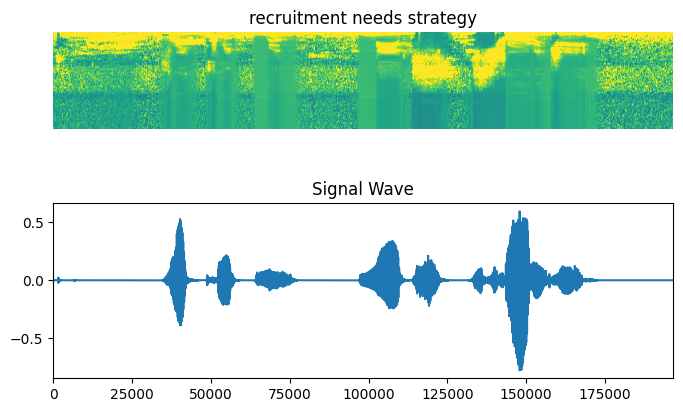

In [96]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(list(df_train["name"])[0] )
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=38000)) #rate=16000))
plt.show()

Modelo

In [97]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


Definimos el modelo

In [98]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    from tensorflow.keras import layers, models, optimizers
    from tensorflow.keras.backend import ctc_batch_cost as CTCLoss

    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]), name="reshape_to_rnn")(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5, name=f"dropout_{i}")(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_activation")(x)  # Renamed to ensure uniqueness
    x = layers.Dropout(rate=0.5, name="dropout_final")(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = models.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = optimizers.Adam(learning_rate=0.0001)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Correct fft_length based on the error message
correct_fft_length = 2 * (193 - 1)

# Rebuild the model with the corrected input dimension
model = build_model(
    input_dim=193,
    output_dim=num_to_char.vocabulary_size(),
    rnn_units=512
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [99]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Entrenamiento y evaluacion

In [100]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [101]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('loss_curve.png')
    #plt.show()

In [102]:
t= time.time()
export= './speech_to_text.h5'
checkpoint_filepath = export

model_checkpoint_callback = ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='loss',
mode='min',
save_best_only=True,
verbose=1)

Iniciamos a entrenar

In [103]:
#model=keras.models.load_model("./speech_to_text_english.h5", custom_objects={"CTCLoss": CTCLoss })
opt = keras.optimizers.Adam(learning_rate=0.0001)#1e-4)
model.compile(optimizer=opt, loss=CTCLoss)

Epoch 1/100
1/1 [==============================] - 4s 4s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : the flight arrived late
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : emotions are natural
Prediction: 
----------------------------------------------------------------------------------------------------

Epoch 1: loss improved from inf to 389.14178, saving model to .\speech_to_text.h5
12/12 [==============================] - 72s 4s/step - loss: 389.1418 - val_loss: 102.0997
Epoch 2/100
1/1 [==============================] - 0s 128ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
---------------------------------------------------

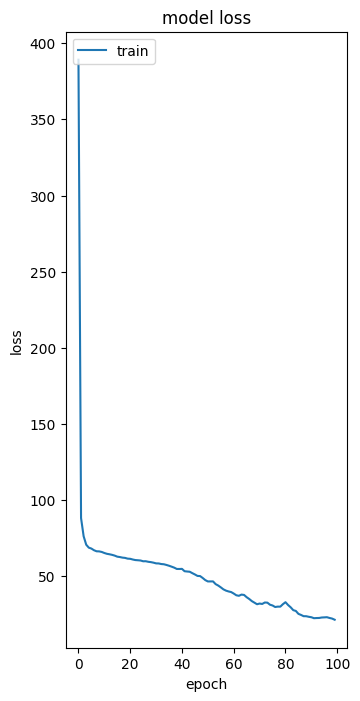

In [104]:
# Define the number of epochs.
epochs = 100
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, MetricsCheckpoint('logs'), model_checkpoint_callback],
    verbose=1
)

plot_learning_curve(history)
plt.show()


Predicciones

In [105]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 [==============================] - 0s 123ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9355
----------------------------------------------------------------------------------------------------
Target    : flight is canceled
Prediction: t is 
----------------------------------------------------------------------------------------------------
Target    : flight at ten
Prediction: t t
----------------------------------------------------------------------------------------------------
Target    : titanic is historic
Prediction: tt is es t
----------------------------------------------------------------------------------------------------
Target    : recruitment is difficult
Prediction: i is 
----------------------------------------------------------------------------------------------------
Target    : recruitment is difficult
Prediction: i is 
-------------------------------------------------------------